In [29]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('charging_session_count_30.csv', index_col=0, parse_dates=['Period'])
df.head()

,Period,Sessions,Cluster
0,2011-07-29 20:00:00,1,HAMILTON
1,2011-07-29 20:30:00,1,HAMILTON
2,2011-07-29 21:00:00,1,HAMILTON
3,2011-07-29 21:30:00,1,HAMILTON
4,2011-07-29 22:00:00,1,HAMILTON


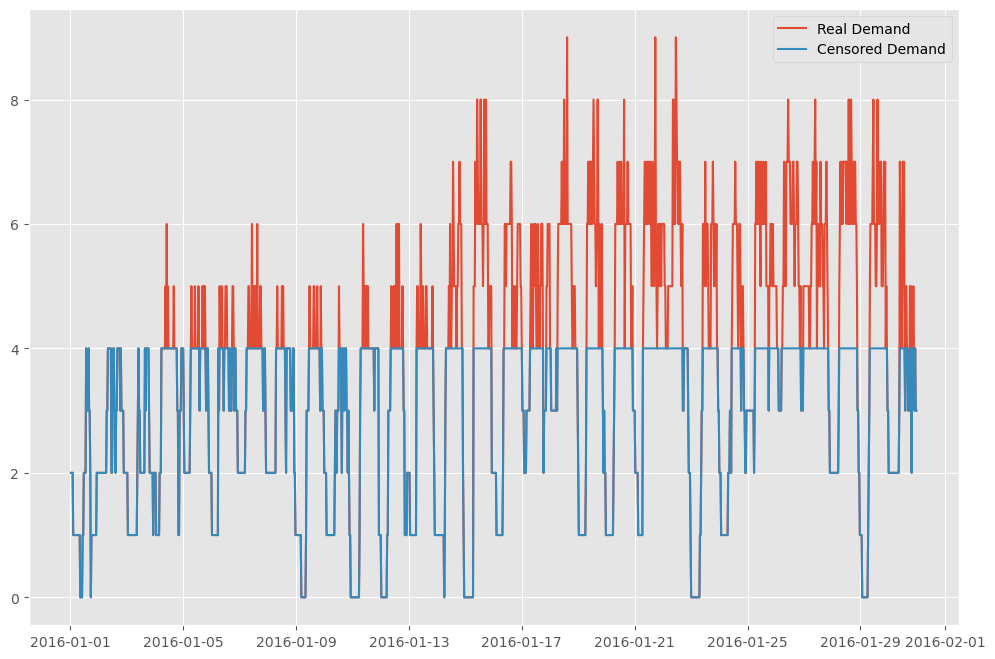

In [30]:

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 8))

df_sample = df[(df.Cluster == 'WEBSTER') & ((df.Period > '2016-01-01') & (df.Period < '2016-01-31'))].copy()
df_sample['Censored'] = df_sample['Sessions'].values

df_sample.loc[df_sample.Sessions > 4, 'Censored'] = 4

plt.plot(df_sample.Period, df_sample.Sessions.values, label='Real Demand')
plt.plot(df_sample.Period, df_sample.Censored.values, label='Censored Demand')
plt.legend()
plt.show()

In [20]:
import torch.nn as nn
import torch

In [69]:
class AR_Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(AR_Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) 

        # Non-linearity
        self.relu = nn.ReLU()

        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim) 

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
class AR(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AR, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim) 

    def forward(self, x):
        out = self.fc1(x)
        return out

In [70]:
input_dim = 48*7
output_dim = 48

X_train = df_sample.reset_index(drop=True).iloc[:input_dim].Sessions.values
y_train = df_sample.reset_index(drop=True).iloc[input_dim:input_dim+output_dim].Sessions.values

model = AR(input_dim, 1)

In [71]:
def train_batch(model, x, y, optimizer, loss_fn):
    # Run forward calculation
    y_predict = model.forward(x)

    # Compute loss.
    loss = loss_fn(y_predict, y)

    optimizer.zero_grad()

    loss.backward(retain_graph=True)

    optimizer.step()

    return loss.data.item()


Epoch: 0 Loss: 10.315730094909668
Epoch: 1 Loss: 20.63579559326172
Epoch: 2 Loss: 36.23933792114258
Epoch: 3 Loss: 44.552001953125
Epoch: 4 Loss: 48.07682418823242
Epoch: 5 Loss: 48.077667236328125
Epoch: 6 Loss: 45.31575393676758
Epoch: 7 Loss: 40.3001594543457
Epoch: 8 Loss: 33.39561080932617
Epoch: 9 Loss: 24.87684440612793
Epoch: 10 Loss: 14.965794563293457
Epoch: 11 Loss: 4.11375093460083
Epoch: 12 Loss: 5.20430326461792
Epoch: 13 Loss: 21.94273567199707
Epoch: 14 Loss: 0.43203005194664
Epoch: 15 Loss: 7.67302942276001
Epoch: 16 Loss: 14.033324241638184
Epoch: 17 Loss: 18.593351364135742
Epoch: 18 Loss: 21.463266372680664
Epoch: 19 Loss: 22.791839599609375
Epoch: 20 Loss: 22.715652465820312
Epoch: 21 Loss: 21.35698699951172
Epoch: 22 Loss: 18.82578468322754
Epoch: 23 Loss: 15.223387718200684
Epoch: 24 Loss: 10.656844139099121
Epoch: 25 Loss: 5.33077335357666
Epoch: 26 Loss: 0.3075288236141205
Epoch: 27 Loss: 3.3004226684570312
Epoch: 28 Loss: 13.65904712677002
Epoch: 29 Loss: -0.4

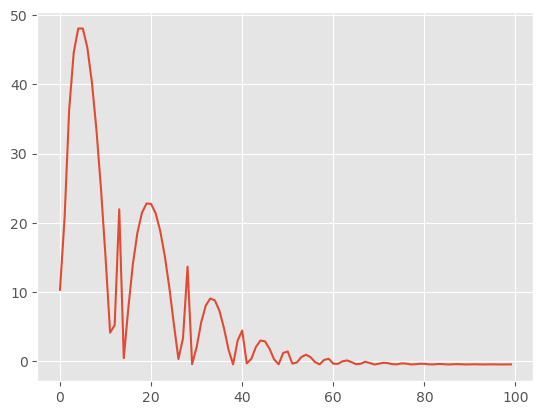

In [72]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.PoissonNLLLoss() 
losses = []
for epoch in range(epochs):
    x = torch.tensor(X_train, dtype=torch.float32).view(1, -1)
    y = torch.tensor(y_train, dtype=torch.float32).view(1, -1)
    loss = train_batch(model, x, y, optimizer, loss_fn)
    losses.append(loss)
    print(f'Epoch: {epoch} Loss: {loss}')
plt.plot(losses)

In [73]:
# make prediction
x = torch.tensor(X_train, dtype=torch.float32).view(1, -1)
y_predict = model.forward(x)
y_predict = y_predict.detach().numpy().reshape(-1)

In [74]:
y_predict

array([1.1945753], dtype=float32)

In [76]:
y_predict

array([1.1945753], dtype=float32)